In [4]:
import torch
import torch.nn as nn
import torch.functional as F
from torchvision import datasets
from torchvision.transforms import ToTensor

from unet_model import UNet

In [7]:
training_data = datasets.FashionMNIST(
    root="data",
    download=True,
    transform=ToTensor()
)

100%|██████████| 26421880/26421880 [00:12<00:00, 2113862.32it/s]


Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 814622.23it/s]


Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:04<00:00, 956778.70it/s] 


Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<?, ?it/s]

Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw



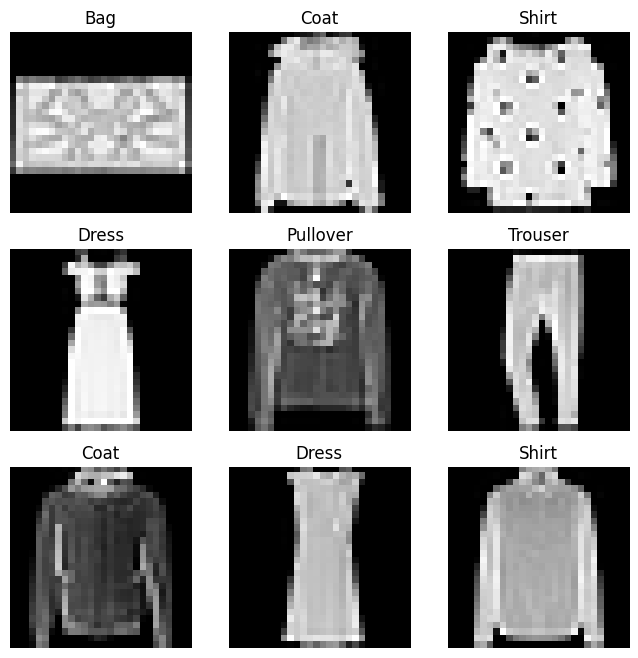

In [8]:
# visualize some images
import matplotlib.pyplot as plt

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [51]:
import os
from tqdm import tqdm
import json
import numpy as np
NUM_CLASSES = 10

def generate_image(model):
    model.eval()
    output = torch.randn((1, 1, 28, 28))
    for i in range(8):
        m = model(output)
        output = output - m
    model.train()
    return output

def train(model, loss_fn, optimizer, scheduler, train_dl, val_dl, device, n_epochs, early_stop_val_acc = 0.6, checkpoint_path = None, logging_path = None):
    if checkpoint_path is not None: os.makedirs(checkpoint_path, exist_ok=True)
    if logging_path is not None: os.makedirs(logging_path, exist_ok=True)

    history = []
    model = model.to(device)
    loss_fn = loss_fn.to(device)

    for epoch in (pbar := tqdm(range(n_epochs))):
        batch_train_accuracies = []
        batch_train_losses = []
        batch_train_times = []
        val_accuracy = 0
        val_loss = 0
        curr_lr = scheduler.get_last_lr()[-1] if scheduler is not None else optimizer.param_groups[-1]['lr']

        # Train
        model.train()
        for i, (image, _) in enumerate(train_dl):
            pbar.set_description(f"Epoch {epoch+1} ({i+1}/{len(train_dl)}) [lr: {curr_lr:.3e}]")
            if device == "cuda":
                start_time = torch.cuda.Event(enable_timing=True)
                end_time = torch.cuda.Event(enable_timing=True)
            # images, labels = images.to(device), labels.to(device)
            image = image.to(device).squeeze(1)
            images = [image]
            for j in range(8):
                noise = torch.randn_like(image) * 0.1
                images.append(images[-1] + noise)
                
            X = torch.stack(images[1:])
            labels = torch.stack(images[:-1])
            
            
            if device == "cuda": start_time.record()
            optimizer.zero_grad()
            # print(images.shape)
            # print(X.shape)
            preds = model(X)
            loss = loss_fn(X + preds, labels)
            loss.backward()
            optimizer.step()
            if device == "cuda": end_time.record()
            
            if i % 10 == 0:
                print(f"Loss: {loss.item()}")
                
            if i % 50 == 0:
                with torch.no_grad():
                    generated = generate_image(model)
                    plt.imshow(generated.squeeze().cpu().numpy(), cmap="gray")
                    plt.show()

            """ _, preds = torch.max(preds, 1)
            batch_train_accuracies.append((preds == labels).sum().item() / labels.size(0))
            batch_train_losses.append(loss.item())
            if device == "cuda":
                torch.cuda.synchronize()
                batch_train_times.append(start_time.elapsed_time(end_time)) """
        if scheduler is not None:
            scheduler.step()

        # Validation
        """ model.eval()
        val_accuracy_per_label_count = np.zeros((NUM_CLASSES, 2))
        with torch.no_grad():
            for images, labels in val_dl:
                images, labels = images.to(device), labels.to(device)
                preds_logits = model(images)
                _, pred = torch.max(preds_logits, 1)
                val_accuracy += (pred == labels).sum().item()
                for class_idx in range(NUM_CLASSES):
                    val_accuracy_per_label_count[class_idx,0] += np.logical_and((pred == labels).cpu().numpy(), (labels == class_idx).cpu().numpy()).sum()
                    val_accuracy_per_label_count[class_idx,1] += (labels == class_idx).sum().item()
                
                val_loss += loss_fn(preds_logits, labels).item() * labels.shape[0]
                
        val_accuracy = val_accuracy / len(val_dl.dataset)
        val_accuracy_per_label_count[val_accuracy_per_label_count[:,1] == 0, 1] = np.inf
        val_accuracy_per_label = val_accuracy_per_label_count[:,0] / val_accuracy_per_label_count[:,1]
        val_loss = val_loss / len(val_dl.dataset) """

        print(
            f"Epoch {epoch + 1:<3} [lr: {curr_lr:.3e}] | "
            # f"train_acc: {np.mean(batch_train_accuracies):.4f} "
            f"train_loss: {np.mean(batch_train_losses):.4f} "
            # f"val_acc: {val_accuracy:.4f} "
            # f"val_loss: {val_loss:.4f}",
        )

        # Checkpoint
        if checkpoint_path is not None:
            torch.save({
                "state_dict": model.state_dict(),
                "architecture": str(model)
            }, os.path.join(checkpoint_path, f"epoch{epoch+1}.ckp.pt"))

        # Logging
        """ epoch_logs = {
            "epoch": epoch + 1,
            "batch_train_accuracies": batch_train_accuracies,
            "batch_train_losses": batch_train_losses,
            "batch_train_times": batch_train_times,
            "val_accuracy": val_accuracy,
            "val_loss": val_loss,
            "val_accuracy_per_label": val_accuracy_per_label.tolist()
        }
        if logging_path is not None:
            with open(os.path.join(logging_path, f"epoch{epoch+1}.log.json"), "w") as f:
                json.dump(epoch_logs, f, indent=3)
        history.append(epoch_logs) """

        """ if (early_stop_val_acc is not None) and (val_accuracy >= early_stop_val_acc):
            break """

    return history

Epoch 1 (1/60000) [lr: 1.000e-03]:   0%|          | 0/10 [00:00<?, ?it/s]

Loss: 0.1749977171421051


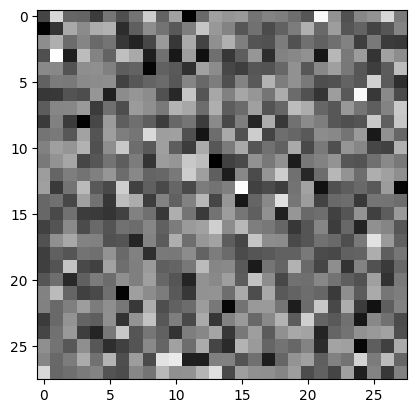

Epoch 1 (12/60000) [lr: 1.000e-03]:   0%|          | 0/10 [00:02<?, ?it/s]

Loss: 0.029372364282608032


Epoch 1 (22/60000) [lr: 1.000e-03]:   0%|          | 0/10 [00:04<?, ?it/s]

Loss: 0.01382286287844181


Epoch 1 (32/60000) [lr: 1.000e-03]:   0%|          | 0/10 [00:07<?, ?it/s]

Loss: 0.010299290530383587


Epoch 1 (42/60000) [lr: 1.000e-03]:   0%|          | 0/10 [00:09<?, ?it/s]

Loss: 0.009940660558640957


Epoch 1 (51/60000) [lr: 1.000e-03]:   0%|          | 0/10 [00:11<?, ?it/s]

Loss: 0.008980236947536469


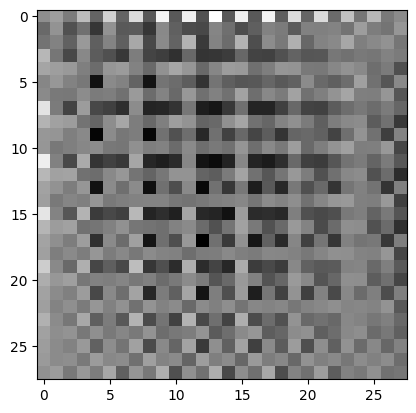

Epoch 1 (62/60000) [lr: 1.000e-03]:   0%|          | 0/10 [00:13<?, ?it/s]

Loss: 0.009149660356342793


Epoch 1 (72/60000) [lr: 1.000e-03]:   0%|          | 0/10 [00:16<?, ?it/s]

Loss: 0.008612791076302528


Epoch 1 (82/60000) [lr: 1.000e-03]:   0%|          | 0/10 [00:18<?, ?it/s]

Loss: 0.008551246486604214


Epoch 1 (92/60000) [lr: 1.000e-03]:   0%|          | 0/10 [00:20<?, ?it/s]

Loss: 0.008655259385704994


Epoch 1 (101/60000) [lr: 1.000e-03]:   0%|          | 0/10 [00:22<?, ?it/s]

Loss: 0.008496432565152645


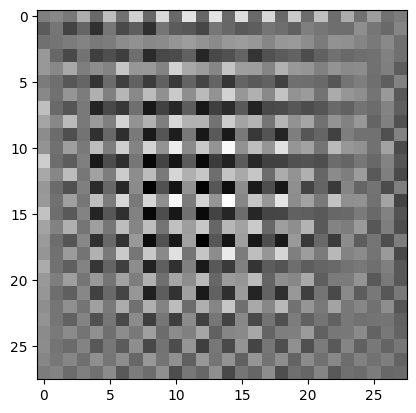

Epoch 1 (112/60000) [lr: 1.000e-03]:   0%|          | 0/10 [00:25<?, ?it/s]

Loss: 0.008372624404728413


Epoch 1 (122/60000) [lr: 1.000e-03]:   0%|          | 0/10 [00:27<?, ?it/s]

Loss: 0.008458209224045277


Epoch 1 (132/60000) [lr: 1.000e-03]:   0%|          | 0/10 [00:30<?, ?it/s]

Loss: 0.008267753757536411


Epoch 1 (142/60000) [lr: 1.000e-03]:   0%|          | 0/10 [00:32<?, ?it/s]

Loss: 0.008772449567914009


Epoch 1 (151/60000) [lr: 1.000e-03]:   0%|          | 0/10 [00:34<?, ?it/s]

Loss: 0.008265302516520023


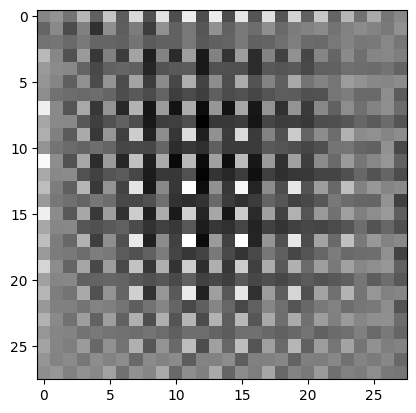

Epoch 1 (162/60000) [lr: 1.000e-03]:   0%|          | 0/10 [00:37<?, ?it/s]

Loss: 0.008817721158266068


Epoch 1 (172/60000) [lr: 1.000e-03]:   0%|          | 0/10 [00:39<?, ?it/s]

Loss: 0.008285517804324627


Epoch 1 (182/60000) [lr: 1.000e-03]:   0%|          | 0/10 [00:41<?, ?it/s]

Loss: 0.008021675981581211


Epoch 1 (188/60000) [lr: 1.000e-03]:   0%|          | 0/10 [00:43<?, ?it/s]


KeyboardInterrupt: 

In [52]:
model = UNet(n_channels=1, n_classes=1)
loss_fn = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

device = "cuda" if torch.cuda.is_available() else "cpu"
n_epochs = 10
train_dl = torch.utils.data.DataLoader(training_data, batch_size=1, shuffle=True)

history = train(model, loss_fn, optimizer, None, train_dl, None, device, n_epochs, early_stop_val_acc=None, checkpoint_path="checkpoints", logging_path="logs")